1. Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения модели на сегментацию губ (обратите внимание, что сегментация подразумевает уже два класса: фон и губы).
2. И затем обучить Модель на выбор из segmentation_models_pytorch
3. *(Усложненное задание) Переделайте архитектуру декодера Unet так, как в этой работе https://www.ics.uci.edu/~haoyum3/papers/slides_icivc.pdf. Эта тема пересекается с темой о второго вебинара о LSTM-сетях. И попробуйте обучить получившуюся нейронную сеть.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
PATH = 'E:/IT_WORK/!!!_GB_Pytorch_28.10.2020/Lession04/Makeup PixelPerfectLipsSegmentation_Data/set-lipstick-original/'

In [3]:
data_list = pd.read_csv(
    PATH + "list.csv"
)

In [4]:
data_list.head(2)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png


In [5]:
cameraRGB = []
cameraSeg = []
cameraSeg_name = []
for root, dirs, files in os.walk(PATH + 'set-lipstick-original'):
    for name in files:
        f = os.path.join(root, name)
        if '720p' in f:
            cameraRGB.append(f)
        elif 'mask' in f:
            cameraSeg.append(f)
            cameraSeg_name.append(name)
        else:
            break

In [6]:
data_list['name_path'] = [f'{PATH}720p/{n}' for n in data_list['filename']]
data_list['mask_path'] = [f'{PATH}mask/{n}' for n in data_list['mask']]


Создадим класс для кастомного датасета:

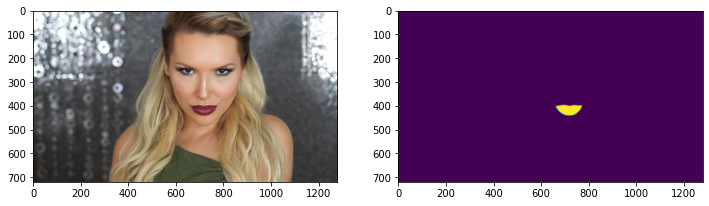

In [7]:
f, axarr = plt.subplots(1, 2, figsize=(12, 12))


axarr[0].imshow(np.asarray(Image.open(data_list.iloc[0]['name_path'])).astype('float')/255)
# axarr[1].imshow(np.asarray(Image.open(data_list.iloc[0]['mask_path'])).astype('float')/255)
axarr[1].imshow((np.asarray(Image.open(data_list.iloc[0]['mask_path'])).astype('float')/255)[:, :, 1])


In [8]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch.nn import functional as F

In [9]:
# В датасете есть пропущенные маски, удалим их из выборки
err_files = []
for _line in data_list.index:
    try:
#         Image.open(_line['mask_path'])
        Image.open(data_list.iloc[_line]['mask_path'])

    except:
        err_files.append(_line)

In [10]:
data_list = data_list.drop(index=err_files, axis=0)

In [66]:
# Удалим битый файл
data_list = data_list[data_list['mask'] != 'mask00000616.png']

In [84]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_list):
        # Подаем наш подготовленный датафрейм
        self.data_list = data_list
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_list['name_path'].to_list()
        # и на сегментированные картинки
        self.label_arr = self.data_list['mask_path'].to_list()
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_list.index)
        
        
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 1280х720 float-значний
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 2) permute - меняет местами измерения , т.е. (1, 720, 1280, 3) -> (1, 3, 720, 1280)
        img = img.unsqueeze(0).permute(0,3,1,2)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с 1280х720 на 256х256
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
#         Читаем маску в нумпай массив
        lab = np.asarray(Image.open(self.label_arr[index])).astype('float')
        lab = torch.as_tensor(lab)/255 
        lab = torch.as_tensor(np.where(lab > 0.9, 0.98, 0)) #Заменим значения выше 0,9 на 0,98
        
#         Оставляем все 3 канала (хотя маска находиться только в одном, но по другому не работет модельу меня)
        try:
            lab = lab.unsqueeze(0).permute(0,3,1,2)
        except:
            print('file** ', self.image_arr[index], '****shape', lab.shape)
            
#         Мы используем функцию интерполяции для того,
#         чтобы поменять рамерность картинки с 1280х720 на 256х256
        lab = F.interpolate(input=lab, size=256, align_corners=False, mode='bicubic')
        
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

Затем разделим наш датасет на тренировочную и тестовую выборки. И обернем их в наш кастомный класс.

In [85]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(data_list,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [86]:
train_data_loader = DataLoader(train_data,batch_size=128,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=128,shuffle=False)

Обучение

In [87]:
#Импортируем библиотеку time для расчета, сколько времени у нас уходит на одну эпоху
import time

In [88]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [89]:
# ! pip install segmentation-models-pytorch

In [90]:
import segmentation_models_pytorch as smp
import torch.nn as nn
from torch.autograd import Variable

In [91]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 0.1
        num = targets.size(0)
        probs = logits
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score =(2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        #print(score.sum())
        score =1 - score.sum() / num
        return score

In [92]:
learning_rate = 0.001
epochs = 10

In [93]:
# создание модели
segmodel = smp.Unet()
# Добавил 3 класса, тк у нас 3 канала в маске. (Но маска сама находиться только в одном канале). Не смог по другому сделать модель правильную
segmodel = smp.Unet('resnet34', classes=3, activation='softmax').to(device)

optimizer = torch.optim.Adam(segmodel.parameters())

criterion = SoftDiceLoss()

epoch_losses = []

for epoch in range(epochs):  # loop over the dataset multiple times
    epoch_loss = []
    time1 = time.time()
    for batch_idx, (data, labels) in enumerate(train_data_loader):
        # get the inputs; data is a list of [inputs, labels]
        data, labels = Variable(data), Variable(labels)        
        data = data.to(device)
        labels = labels.to(device)


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = segmodel(data[0])
        loss = criterion(outputs,labels[0,0,:,:])
    
        loss.backward()
        optimizer.step()

        # print statistics
        epoch_loss.append(loss.item())
#         print(f'batch index : {batch_idx} | loss : {loss.item()}')

    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss))
    time2 = time.time()
    print(f'Spend time for 1 epoch: {time2-time1} sec')
    
    epoch_losses.append(epoch_loss)

Epoch 1, loss:  0.8372549426024127
Spend time for 1 epoch: 1703.7268080711365 sec
Epoch 2, loss:  0.7473803686488206
Spend time for 1 epoch: 1649.694262266159 sec
Epoch 3, loss:  0.7376846788795131
Spend time for 1 epoch: 1638.2889602184296 sec
Epoch 4, loss:  0.7208920140175303
Spend time for 1 epoch: 1646.9515068531036 sec
Epoch 5, loss:  0.7120350937175143
Spend time for 1 epoch: 1635.9040768146515 sec
Epoch 6, loss:  0.7124242103023893
Spend time for 1 epoch: 1629.5179426670074 sec
Epoch 7, loss:  0.7052324099145877
Spend time for 1 epoch: 1639.316722869873 sec
Epoch 8, loss:  0.7039334591786572
Spend time for 1 epoch: 1641.7776312828064 sec
Epoch 9, loss:  0.7244690485820648
Spend time for 1 epoch: 1630.2710819244385 sec
Epoch 10, loss:  0.710483013064998
Spend time for 1 epoch: 1637.3786790370941 sec


Сохраним нашу модель:

In [94]:
savePATH = './selfLastModel_NW_Unet.pth'

In [95]:
torch.save(segmodel.state_dict(), savePATH)

In [96]:
net=smp.Unet('resnet34', classes=3, activation='softmax')
net.load_state_dict(torch.load(savePATH))

<All keys matched successfully>

In [97]:
def get_orig(image):
    #image = images[0,:,:,:]
    image = image.permute(1, 2, 0)
    image = image.numpy()
    image = np.clip(image, 0, 1)
    return image

In [98]:
from scipy.special import softmax

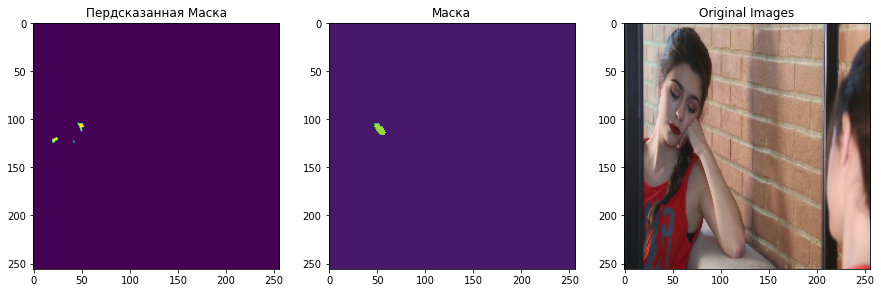

<ipython-input-99-3773b31eeba3>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.gcf().show()


<Figure size 432x288 with 0 Axes>

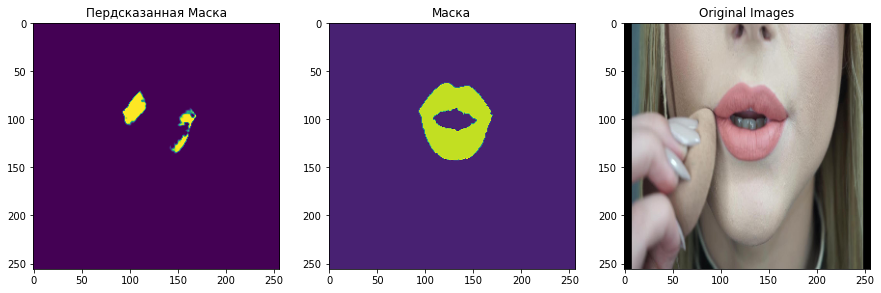

<Figure size 432x288 with 0 Axes>

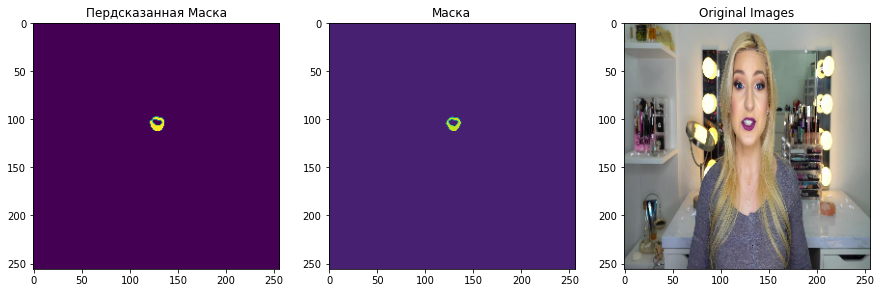

<Figure size 432x288 with 0 Axes>

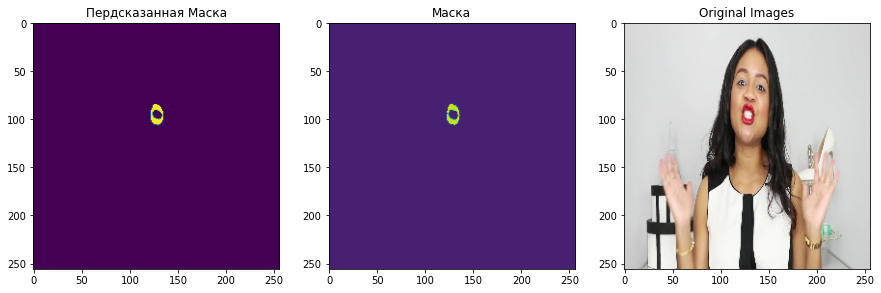

<Figure size 432x288 with 0 Axes>

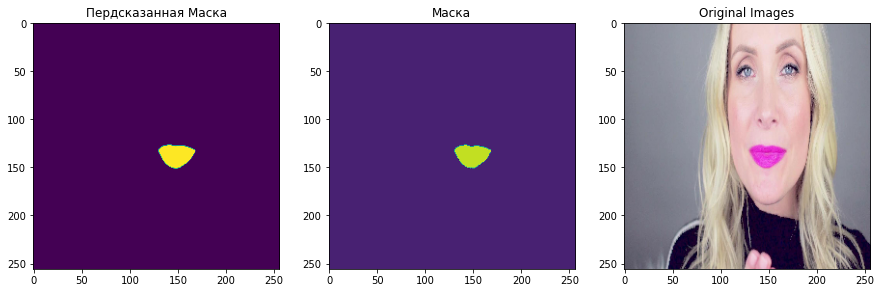

<Figure size 432x288 with 0 Axes>

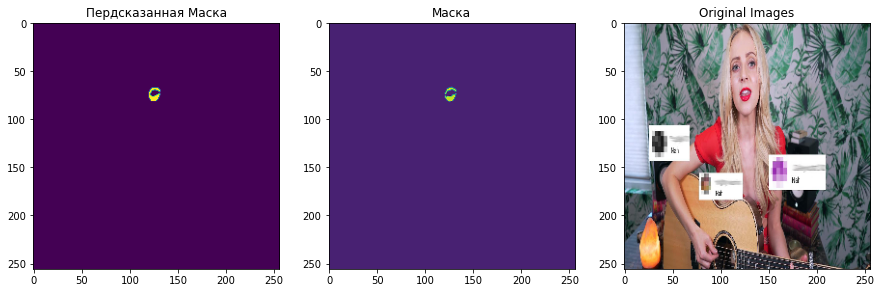

<Figure size 432x288 with 0 Axes>

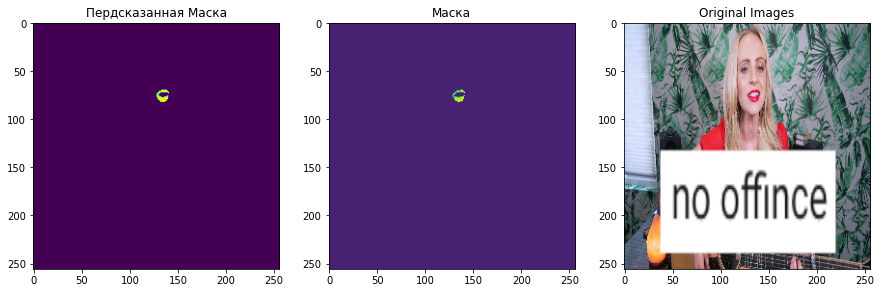

<Figure size 432x288 with 0 Axes>

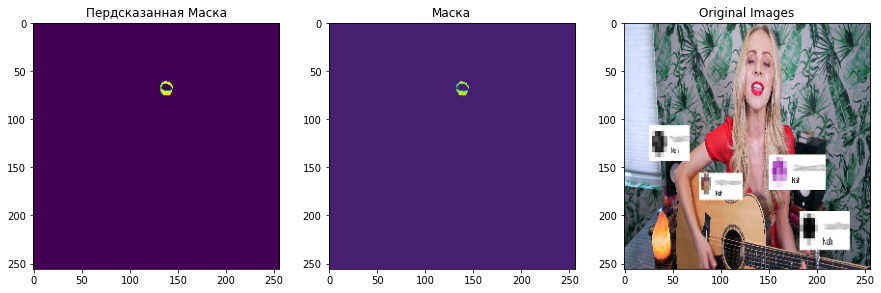

<Figure size 432x288 with 0 Axes>

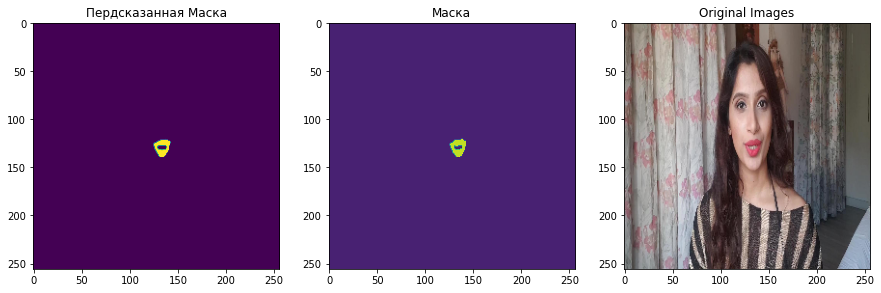

<Figure size 432x288 with 0 Axes>

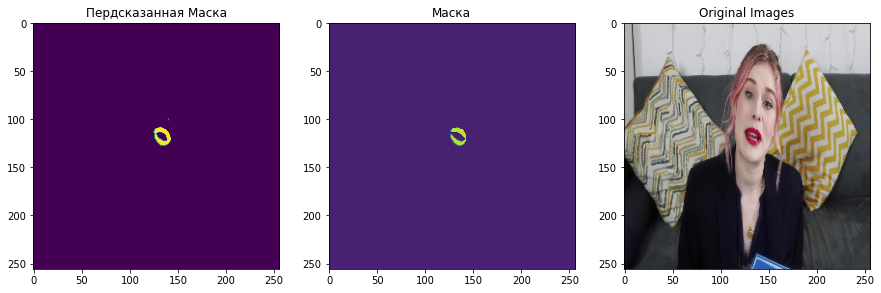

<Figure size 432x288 with 0 Axes>

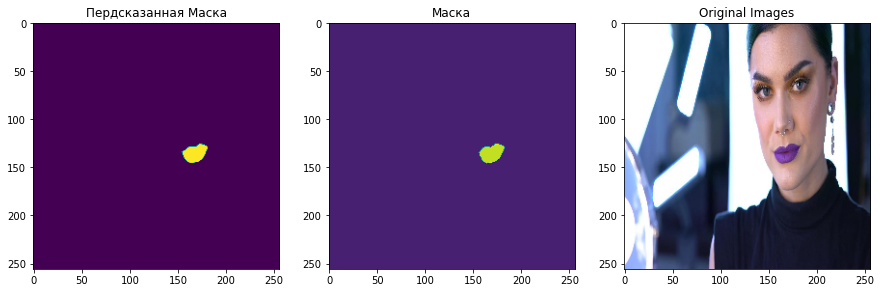

<Figure size 432x288 with 0 Axes>

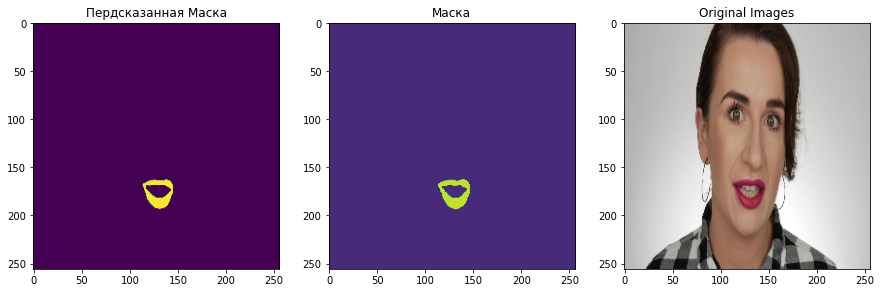

<Figure size 432x288 with 0 Axes>

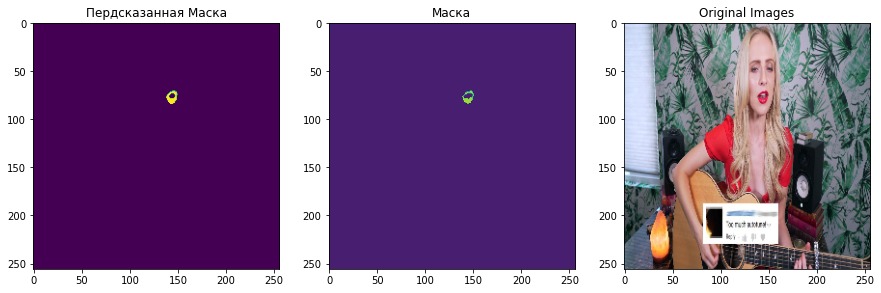

<Figure size 432x288 with 0 Axes>

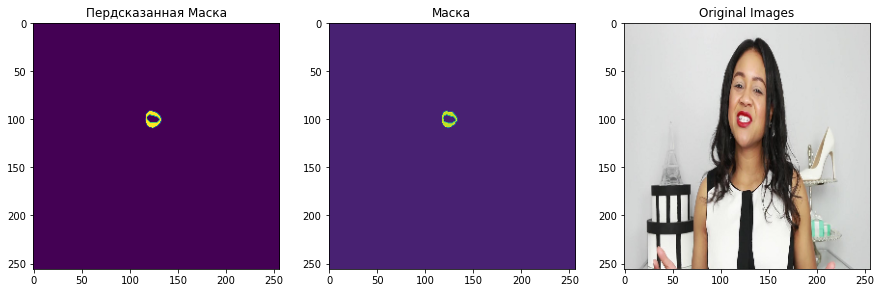

<Figure size 432x288 with 0 Axes>

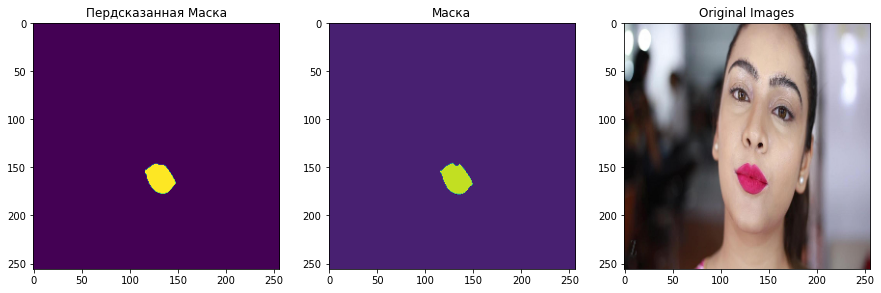

<Figure size 432x288 with 0 Axes>

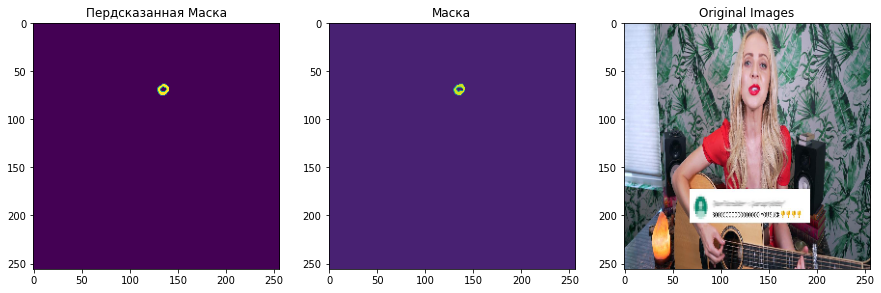

<Figure size 432x288 with 0 Axes>

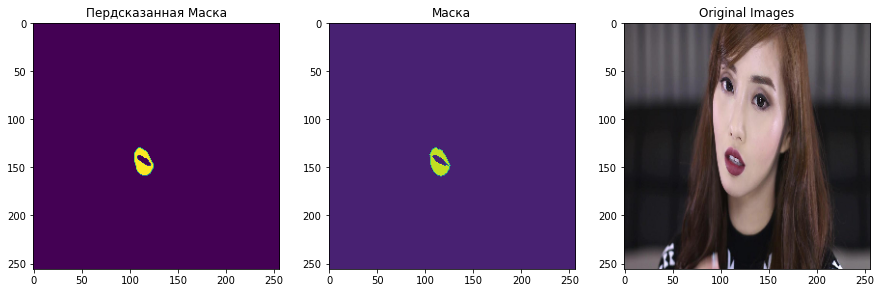

<Figure size 432x288 with 0 Axes>

In [99]:
num = 5
for i, data in enumerate(test_data_loader):
    images, labels = data
    outputs = net(images[i])#.to(device)
    
    f, axarr = plt.subplots(1, 3, figsize=(15, 15))
    axarr[0].imshow(outputs.detach().numpy()[0,1,:,:])
    axarr[0].set_title('Пердсказанная Маска')

    axarr[1].imshow(labels[i].detach().numpy()[0,1,:,:])
    axarr[1].set_title('Маска')

    original = get_orig(images[i][0,:,:,:])
    axarr[2].imshow(original)
    axarr[2].set_title('Original Images')

    plt.show()
    plt.gcf().show()
    if i > 15:
        break 